In [80]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="model2/Loom _ presentacion_test_app.mp4" type="video/mp4">
</video></div>



In [1]:
#####  LOADING AND EXTRACTING DATA   #####


import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle


#Modelo
def data_loader():
    
    # Load dataset file
    data_frame = pd.read_csv('model2/training.csv')
    data_frame.head()
    data_frame['Image'] = data_frame['Image'].apply(lambda i: np.fromstring(i, sep=' '))
    data_frame = data_frame.dropna()  # Get only the data with 15 keypoints
   
    # Extract Images pixel values
    imgs_array = np.vstack(data_frame['Image'].values)/ 255.0
    imgs_array = imgs_array.astype(np.float32)    # Normalize, target values to (0, 1)
    imgs_array = imgs_array.reshape(-1, 96, 96, 1)
        
    # Extract labels (key point cords)
    labels_array = data_frame[data_frame.columns[:-1]].values
    labels_array = (labels_array - 48) / 48    # Normalize, traget cordinates to (-1, 1)
    labels_array = labels_array.astype(np.float32) 
   
   
    # shuffle the train data
#     imgs_array, labels_array = shuffle(imgs_array, labels_array, random_state=9)  
    
    return imgs_array, labels_array

  


# # This snippet is just to check/verify data

#imgs, labels = data_loader()
#print(imgs.shape)
#print(labels.shape)
#print(labels)

#n=1
#labels[n] = (labels[n]*48)+48
#image = np.squeeze(imgs[n])
#plt.imshow(image, cmap='gray')
#plt.plot(labels[n][::2], labels[n][1::2], 'ro')
#plt.show()
    

In [2]:
######   BUILD, TRAIN AND SAVE THE CONVOLUTIONAL MODEL    ########


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Activation
from keras.layers import Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History
# from keras.optimizers import Adam


# Main model
def the_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train.shape[1:])) # Input shape: (96, 96, 1)
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    
    # Convert all values to 1D array
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(30))
    
    return model


X_train, y_train = data_loader()
print("Training datapoint shape: X_train.shape:{}".format(X_train.shape))
print("Training labels shape: y_train.shape:{}".format(y_train.shape))


epochs = 60
batch_size = 64

model = the_model()
hist = History()

checkpointer = ModelCheckpoint(filepath='checkpoint1.hdf5', 
                               verbose=1, save_best_only=True)

# Complie Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model_fit = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, hist], verbose=1)

model.save('model2/model1.h5')




Using TensorFlow backend.


Training datapoint shape: X_train.shape:(2140, 96, 96, 1)
Training labels shape: y_train.shape:(2140, 30)
Train on 1712 samples, validate on 428 samples
Epoch 1/60
1712/1712 [==============================] - 12s 7ms/step - loss: 0.0230 - accuracy: 0.5502 - val_loss: 0.0093 - val_accuracy: 0.4322

Epoch 00001: val_loss improved from inf to 0.00928, saving model to checkpoint1.hdf5
Epoch 2/60
1712/1712 [==============================] - 11s 7ms/step - loss: 0.0068 - accuracy: 0.6554 - val_loss: 0.0078 - val_accuracy: 0.4322

Epoch 00002: val_loss improved from 0.00928 to 0.00775, saving model to checkpoint1.hdf5
Epoch 3/60
1712/1712 [==============================] - 11s 6ms/step - loss: 0.0060 - accuracy: 0.6928 - val_loss: 0.0074 - val_accuracy: 0.4322

Epoch 00003: val_loss improved from 0.00775 to 0.00741, saving model to checkpoint1.hdf5
Epoch 4/60
1712/1712 [==============================] - 11s 7ms/step - loss: 0.0053 - accuracy: 0.7097 - val_loss: 0.0075 - val_accuracy: 0.4322



1712/1712 [==============================] - 11s 6ms/step - loss: 0.0010 - accuracy: 0.8493 - val_loss: 0.0036 - val_accuracy: 0.4930

Epoch 00037: val_loss did not improve from 0.00349
Epoch 38/60
1712/1712 [==============================] - 11s 6ms/step - loss: 9.8055e-04 - accuracy: 0.8610 - val_loss: 0.0035 - val_accuracy: 0.5561

Epoch 00038: val_loss improved from 0.00349 to 0.00349, saving model to checkpoint1.hdf5
Epoch 39/60
1712/1712 [==============================] - 11s 7ms/step - loss: 9.3223e-04 - accuracy: 0.8604 - val_loss: 0.0035 - val_accuracy: 0.5444

Epoch 00039: val_loss improved from 0.00349 to 0.00345, saving model to checkpoint1.hdf5
Epoch 40/60
1712/1712 [==============================] - 11s 6ms/step - loss: 8.8596e-04 - accuracy: 0.8540 - val_loss: 0.0034 - val_accuracy: 0.5584

Epoch 00040: val_loss improved from 0.00345 to 0.00339, saving model to checkpoint1.hdf5
Epoch 41/60
1712/1712 [==============================] - 11s 6ms/step - loss: 9.0717e-04 - acc

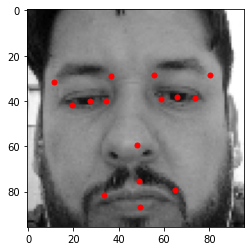

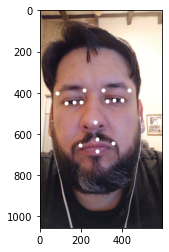

In [3]:
#####  TEST YOUR IMAGE FILE WITH THE MODEL  #####
# Imprime los keypoints en el rostro

import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import time
import imageio
import os


# Load the saved model
from keras.models import load_model
model = load_model('model1.h5')  # <-- Saved model path


def detect_points(face_img):
    me  = np.array(face_img)/255
    x_test = np.expand_dims(me, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = model.predict(x_test)
    label_points = (np.squeeze(y_test)*48)+48 
    
    return label_points
    
# Load haarcascade
face_cascade = cv2.CascadeClassifier('model2/haarcascade_frontalface_default.xml')
dimensions = (96, 96)

# Enter the path to your test image
img = cv2.imread('model2/ochr2.jpg')

default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
# faces = face_cascade.detectMultiScale(gray_img, 4, 6)

faces_img = np.copy(gray_img)

plt.rcParams["axes.grid"] = False


all_x_cords = []
all_y_cords = []

for i, (x,y,w,h) in enumerate(faces):
    
    h += 10
    w += 10
    x -= 5
    y -= 5
    
    just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
    cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)
    
    scale_val_x = w/96
    scale_val_y = h/96
    
    label_point = detect_points(just_face)
    all_x_cords.append((label_point[::2]*scale_val_x)+x)
    all_y_cords.append((label_point[1::2]*scale_val_y)+y)
   
   
    plt.imshow(just_face, cmap='gray')
    plt.plot(label_point[::2], label_point[1::2], 'ro', markersize=5)
    plt.show()
    
    
plt.imshow(default_img)    
plt.plot(all_x_cords, all_y_cords, 'wo',  markersize=3)
plt.show()




In [75]:
####  Insertar Video en la imagen de la Webcam  #####


from keras.models import load_model
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import cv2
import imageio
import os


model = load_model('model1.h5')  # <-- modelo salvado 

#Carga imagenes png 
bigote_img = imageio.imread("images/bigote2x.png") # images/bigote2.png
mascara = imageio.imread("images/stormtrooper-ojos-transparentes.png") #stormtrooper-ojos-transparentes.png
lenterojo_img = imageio.imread("images/lenterojo.png")
sombrero_img = imageio.imread("images/sombrerox.png")
tapaboca_img = imageio.imread("images/tapaboca.png")
stormtroopere_img = imageio.imread("images/stormtrooper-ojos-transparentes.png")
# Get Image dimensions



x = 50
y = 50
pc = {
    'x':20, 'y':20,
    'w':50, 'h':50
} 
pa = {
    'x': 320, 'y': 20,
    'w': 50, 'h': 50
}

#Redimensiona la imagen
bigote_img_chico = cv2.resize(bigote_img, (200, 100 )) 
sombrero_img_chico = cv2.resize(sombrero_img, (150, 150)) 
lenterojo_img_chico = cv2.resize(lenterojo_img, (250, 100 )) 
mascara_chico = cv2.resize(mascara, (50, 50) )
stormtrooper_img_chico = cv2.resize(mascara, (300, 300) )


def get_points_main(img):

    def detect_points(face_img):
        me  = np.array(face_img)/255
        x_test = np.expand_dims(me, axis=0)
        x_test = np.expand_dims(x_test, axis=3)

        y_test = model.predict(x_test)
        label_points = (np.squeeze(y_test)*48)+48


        return label_points
    

    # load haarcascade
    face_cascade = cv2.CascadeClassifier('model2/haarcascade_frontalface_default.xml')
    dimensions = (96, 96)


    try:
        default_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray_img = cv2.cvtColor(default_img, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
#         faces = face_cascade.detectMultiScale(gray_img, 4, 6)

    except:
        return []

    faces_img = np.copy(gray_img)

    plt.rcParams["axes.grid"] = False


    all_x_cords = []
    all_y_cords = []


    for i, (x,y,w,h) in enumerate(faces):

        h += 10
        w += 10
        x -= 5
        y -= 5

        try:
            just_face = cv2.resize(gray_img[y:y+h,x:x+w], dimensions)
        except:
            return []
        cv2.rectangle(faces_img,(x,y),(x+w,y+h),(255,0,0),1)

        scale_val_x = w/96
        scale_val_y = h/96

        label_point = detect_points(just_face)

        all_x_cords.append((label_point[::2]*scale_val_x)+x)
        all_y_cords.append((label_point[1::2]*scale_val_y)+y)



    final_points_list = []
    try:
        for ii in range(len(all_x_cords)):
            for a_x, a_y in zip(all_x_cords[ii], all_y_cords[ii]):
                final_points_list.append([a_x, a_y])
    except:
        return final_points_list

    return final_points_list

cap = cv2.VideoCapture(0)

ret, frame = cap.read()

height, width, channel = frame.shape


# Array para ubicar localizaciòn los keypoints  
tags = ['','Bigote','','Barba','','','','','','','Nariz','','Ojo1','','Ojo2']
ojo1 = 0
ojo2 = 0
nariz = 0
bigote = 0
barba = 0
sombrero = 0
storm = 0

# funcion para insertar imagen en video 
def agregar_imagen(fondo, imagen, x, y):
    # verificar si la imagen tiene informacion de opacidad
    alto = imagen.shape[0]
    ancho = imagen.shape[1]
    if imagen.shape[-1] == 4:
        # normalizar la opacidad
        opacidad = imagen[:,:,3]/255
        # alpha blending
        #print(f" imagen.shape[-1] {imagen.shape[-1]}")
        # generar una imagen vacia
        imagen_3_canales = np.zeros((imagen.shape[0], imagen.shape[1], 3))
        
        # a cada canal multiplicarle la opacidad
        imagen_3_canales[:,:,0] = imagen[:,:,0] * opacidad
        imagen_3_canales[:,:,1] = imagen[:,:,1] * opacidad
        imagen_3_canales[:,:,2] = imagen[:,:,2] * opacidad

        # a la imagen de fondo, se le suma la imagen con informacion de opacidad
        fondo[y:y+alto, x:x+ancho, :] = (1-np.stack([opacidad, opacidad, opacidad], axis=-1)) * fondo[y:y+alto, x:x+ancho, :] + imagen_3_canales
    else:
        # reemplazamos la informacion del fondo
        fondo[y:y+alto, x:x+ancho, :] = imagen
# funcion para inserar imagen en video
def agregar_imagen_a_imagen(img_a, img_b, x, y):
    # determinar si la imagen b tiene información de la opacidad
    #print(f"img_b.shape[-1] {img_b.shape[-1]} ")
    if img_b.shape[-1] == 4: # existe canal de opacidad
        #print(f"img_b.shape[-1] {img_b.shape[-1]} ")
        # pixeles que no son transparentes
        mask = (img_b != 0).all(axis=2)
        
        # la porcion de la imagen A que reemplazaria con o sin transparencia
        bg = img_a[y:y+img_b.shape[0], x:x+img_b.shape[1], :]
        
        # copiando pixeles no transparentes de B a A
        bg[mask] = img_b[mask, :3]  
        
        img_a[y:y+img_b.shape[0], x:x+img_b.shape[1], :] = bg
    else:
        #print(f"else img_b.shape[-1] {img_b.shape[-1]} ")
        img_a[y:y+img_b.shape[0], x:x+img_b.shape[1], :] = img_b

while(True):
  # la captura se llama frame 
  ret, frame = cap.read()
  frame = cv2.flip( frame, 1 ) # flip horizontal para que sea un espejo  
  points = get_points_main(frame)
  #agregar_imagen_a_imagen(frame, bigote_img_chico, pa['x'], pa['y'])

  try:
     overlay = frame  #.copy()
  except Exception as e:
       print(e)
       break
  i = 0
  for point in points:
      
      i= i+1 # o_line_points son los puntos en tuplas de keypoints en el loog
  if len(points) != 0:
       o_line_points = [[12,13], [13,11], [11,14], [14,12], [12,10], [11,10], [10,3], [12,5], [11,3], [10,5], [10,4], [10,2], [5,1], [1,4], [2,0]]#, [0,3], [5,9], [9,8], [8,4], [2,6], [6,7], [7,3]]
       # Numero de Rostros detectados 
       num_face = len(points)//15    
       
       for i in range(num_face):
           line_points = np.array(o_line_points) + (15*(i))
           
           the_color = (189, 195, 199)
           j = 0 
           for ii in line_points:
                
                # Ejemplo: Si ojo està en 1, y es la posicion del ojo, inserta la imaggen mediante la funcion
                # en la posiciòn adecuada.
                #cv2.line(overlay, tuple(points[ii[0]]), tuple(points[ii[1]]), the_color, thickness=1)
                
                #pa = {'x': int(round(float(str(points[ii[0]][0])))), 'y': int(round(float(str(points[ii[0]][1])))),'w': 50, 'h': 50}
                
                agregar_imagen(frame, mascara_chico, 100, 180)
                
                #nariz = 0 if nariz == 0 else cv2.putText(overlay, str(tags[10]), tuple(points[ii[0]]), 1, 1, (255, 255, 255))
                if (ojo1 == 1 and j == 12):cv2.putText(overlay, str(tags[j]), tuple(points[ii[0]]), 1, 1, (255, 255, 255))
                if (ojo1 == 1 and j == 12):pa = {'x': int(round(float(str(points[ii[0]][0])))) - 80, 'y': int(round(float(str(points[ii[0]][1])))) - 25,'w': 50, 'h': 50}
                if (ojo1 == 1 and j == 12):agregar_imagen_a_imagen(frame, lenterojo_img_chico, pa['x'], pa['y'])
                
                if (sombrero == 1 and j == 9):pa = {'x': int(round(float(str(points[ii[0]][0])))) - 50, 'y': int(round(float(str(points[ii[0]][1])))) - 200,'w': 250, 'h': 250}
                if (sombrero == 1 and j == 9):agregar_imagen_a_imagen(frame, sombrero_img_chico, pa['x'], pa['y'])
                
                #if (ojo2 == 1 and j == 14):cv2.putText(overlay, str(tags[j]), tuple(points[ii[0]]), 1, 1, (255, 255, 255))    
                if (storm == 1 and j == 14):pa = {'x': int(round(float(str(points[ii[0]][0])))) -10 , 'y': int(round(float(str(points[ii[0]][1])))) +10 ,'w': 50, 'h': 50}
                if (storm == 1 and j == 14):agregar_imagen(frame, stormtrooper_img_chico, pa['x'], pa['y'])
                
                
                if (nariz == 1 and j == 10):cv2.putText(overlay, str(tags[j]), tuple(points[ii[0]]), 1, 1, (255, 255, 255))
                #if (nariz == 1 and j == 10):pa = {'x': int(round(float(str(points[ii[0]][0])))) -10 , 'y': int(round(float(str(points[ii[0]][1])))) +10 ,'w': 50, 'h': 50}
                #if (nariz == 1 and j == 10):agregar_imagen(frame, bigote_img_chico, pa['x'], pa['y'])    
                if (bigote == 1 and j == 1):cv2.putText(overlay, str(tags[j]), tuple(points[ii[0]]), 1, 1, (255, 255, 255))
                #if (bigote == 1 and j == 1):cv2.imshow('frame',bigote_img_chico)
                #if (bigote == 1 and j == 1):frame[bigy:bigy+big_height , bigx:bigx+big_width] = big
                #if (bigote == 1 and j == 1): agregar_imagen_a_imagen(frame, bigote_img_chico, pa['x'], pa['y'])
                #print(f"pa['x'] {pa['x']} - pa['y'] {pa['y']} ")
                #frame[ tuple(points[ii[0]]), tuple(points[ii[1]]) ] = big
                #print(f"tuple(points[ii[0]]) {tuple(points[ii[0]])} - tuple(points[ii[1]]) {tuple(points[ii[1]])}")
                #print(f"[points[ii[0]][0]] {[points[ii[0]][0]]} - [points[ii[0]][1]] {[points[ii[0]][1]]}")
                
                #if (barba == 1 and j == 3):agregar_imagen_a_imagen(frame, sombrero_img_chico, pa['x'], pa['y'])
                if (barba == 1 and j == 3):cv2.putText(overlay, str(tags[j]), tuple(points[ii[0]]), 1, 1, (255, 255, 255))    
                cv2.putText(overlay, str(f"Presione una letra para insertar o quitar imagen"), (10,50), 1, 1, (255, 255, 255))
                cv2.putText(overlay, str(f"s = Sombrero"), (10,70), 1, 1, (255, 255, 255))
                cv2.putText(overlay, str(f"o = Anteojos"), (10,90), 1, 1, (255, 255, 255))
                cv2.putText(overlay, str(f"b = Bigote (Da error)"), (10,110), 1, 1, (255, 255, 255))
                cv2.putText(overlay, str(f"r = Barba (Da error)"), (10,130), 1, 1, (255, 255, 255))
                cv2.putText(overlay, str(f"t = Máscara (Da error)"), (10,150), 1, 1, (255, 255, 255))
                cv2.putText(overlay, str(f"n = Nariz"), (10,60), 1, 1, (255, 255, 255))
                #cv2.putText(overlay, str(tags[j]), tuple(points[ii[0]]), 1, 1, (255, 255, 255))
                #cv2.putText(overlay, str(j), tuple(points[ii[0]]), 1, 1, (255, 255, 255))
                the_color = (189, 195, 199)
                #cv2.circle(frame, (tuple(points[ii[0]])), 5, (0, 255, 0), -1)
                #cv2.circle(frame, (tuple(points[ii[1]])), 5, (255, 0, 0), -1)
                #print(f"Indice J es, {j},tuple(points[ii[0]])=,{tuple(points[ii[0]])},tuple(points[ii[1]]),{tuple(points[ii[1]])}")
                #print(f"{j}, {ii},{num_face},{tuple(points[ii[0]])},{tuple(points[ii[1]])},{tuple(point)} , ")
                #cv2.putText(overlay, str(tags[j]), (tuple(points[ii])), 1, 1, (255, 255, 255))
                #cv2.putText(overlay, str(point[0] ), tuple(point), 1, 1, (255, 255, 255))
                #cv2.circle(frame, (tuple(point)), 1, (0, 255, 0), -1)
                #cv2.circle(frame, (tuple(point)), 1, (0, 255, 0), -1)
                #j = j = 14 ? 0 : j + 1
                j = 0 if j == 14 else j+1
                
                k = cv2.waitKey(1)
                
                if k == ord('q'):
                    #print("Pressed q")
                    break
                    
                elif k == ord('n'):
                    nariz = 0 if nariz == 1 else 1
                    print(f"Pressed n nariz = {nariz}")
                elif k== ord('o'):
                    ojo1 = 0 if ojo1 == 1 else 1
                    ojo2 = 0 if ojo2 == 1 else 1
                    print(f"Pressed o ojo1 = {ojo1}")
                   
      
                elif k== ord('b'):
                    bigote = 0 if bigote == 1 else 1
                    print(f"Pressed b bigote = {bigote}")
                elif k== ord('s'):
                    sombrero = 0 if sombrero == 1 else 1
                    print(f"Pressed s sombrero = {sombrero}") 
                elif k== ord('t'):
                    storm = 0 if storm == 1 else 1
                    print(f"Pressed t storm = {storm}")     
                elif k== ord('r'):
                    barba = 0 if barba == 1 else 1     
                    print(f"Pressed r barba = {barba}")
                
           

  #opacity = 0.3
  #cv2.addWeighted(overlay, opacity, frame, 1 - opacity, 0, frame)
        
  #out.write(frame)
  if k == ord('q'):
      #print("sale por q")
      break
  else:      
      cv2.imshow('frame',frame)

cap.release()
cv2.destroyAllWindows()


Pressed s sombrero = 1
Pressed s sombrero = 0
Pressed o ojo1 = 1
Pressed o ojo1 = 0
Pressed n nariz = 1
Pressed b bigote = 1
Pressed r barba = 1
Pressed r barba = 0
Pressed r barba = 1
Pressed r barba = 0
Pressed n nariz = 0
Pressed n nariz = 1
Pressed n nariz = 0
Pressed o ojo1 = 1
Pressed o ojo1 = 0
Pressed o ojo1 = 1
Pressed o ojo1 = 0
Pressed s sombrero = 1
Pressed o ojo1 = 1
Pressed t storm = 1


ValueError: operands could not be broadcast together with shapes (300,300,3) (260,300,3) 

In [76]:
cap.release()
cv2.destroyAllWindows()

In [77]:
https://www.loom.com/share/9159fc90de2c43ecb06d228ffba0b8b2

SyntaxError: invalid syntax (<ipython-input-77-e1bd063f567a>, line 1)